In [ ]:
import tensorflow as tf
tf.__version__
#!pip install imageio
#!pip install git+https://github.com/tensorflow/docs

'2.5.0'

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

In [ ]:
(train_images, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()
train_shape = train_images.shape
print("Training set shape: ", train_shape)

# Add 4th channel to the training set for compatibility with the Keras model we will make
train_images = train_images.reshape(train_shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

Training set shape:  (60000, 28, 28)


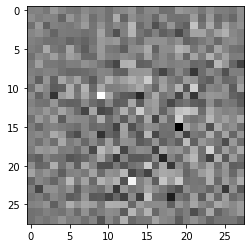

In [ ]:
# GAN Generator model which takes a size 100 seed vector as input and returns a 28x28 image as output
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

generator = make_generator_model()
gen_input = np.random.rand(1, 100)
gen_image = generator(gen_input, training = False)
gen_image.shape
plt.imshow(gen_image[0, :, :, 0], cmap='gray')

In [ ]:
# GAN Discriminator model which takes a 28x28x1 image as input and returns a numeric value as output
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
decision = discriminator(gen_image, training = False)
print(decision)

tf.Tensor([[7.000072e-05]], shape=(1, 1), dtype=float32)


In [ ]:
# Define the loss functions and optimizers for the 2 models

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def get_disc_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def get_gen_loss(fake_output):
  gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
  return gen_loss

gen_opt = tf.keras.optimizers.Adam(1e-4)
disc_opt = tf.keras.optimizers.Adam(1e-4)

In [ ]:
@tf.function
def train_step(images):
  noise = tf.random.normal([batch_size, seed_size])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_images = generator(noise, training = True)

    real_output = discriminator(images, training = True)
    fake_output = discriminator(gen_images, training = True)

    gen_loss = get_gen_loss(fake_output)
    disc_loss = get_disc_loss(real_output, fake_output)
  
  gen_grad = gen_tape.gradient(gen_loss, generator.trainable_variables)
  disc_grad = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  gen_opt.apply_gradients(zip(gen_grad, generator.trainable_variables))
  disc_opt.apply_gradients(zip(disc_grad, discriminator.trainable_variables))
  return gen_loss, disc_loss

def train(dataset, epochs):
  for epoch in range(epochs):
    total_gen_loss = 0
    total_disc_loss = 0
    start = time.time()
    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      total_gen_loss += float(gen_loss)
      total_disc_loss += float(disc_loss)
    #display.clear_output(wait=True)
    display_image(generator, epoch+1, seed)
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print("Epoch:{} Loss: g:{} d:{}".format(epoch + 1, total_gen_loss/(buffer_size/batch_size), total_disc_loss/(buffer_size/batch_size)))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print("___________________________________")
    

def display_image(model, epoch, seed):
  print(epoch)
  current_gen_img = model(seed, training = False)
  fig = plt.figure(figsize=(10, 10))
  for i in range(current_gen_img.shape[0]):
      plt.subplot(1, 5, i+1)
      plt.imshow(current_gen_img[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

1


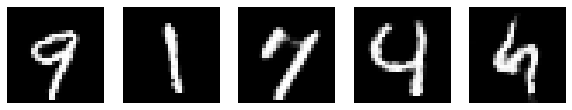

Epoch:1 Loss: g:0.8523613178571066 d:1.2906076218922933
Time for epoch 1 is 42.56345176696777 sec
___________________________________
2


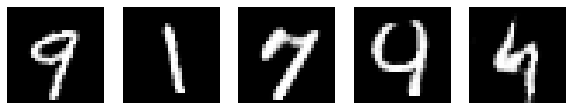

Epoch:2 Loss: g:0.8527382746060689 d:1.2911819130579631
Time for epoch 2 is 42.50561571121216 sec
___________________________________
3


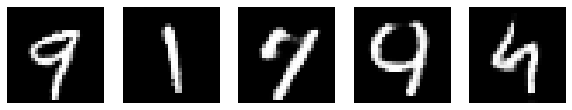

Epoch:3 Loss: g:0.8497596631050109 d:1.2943989892959595
Time for epoch 3 is 42.207754373550415 sec
___________________________________
4


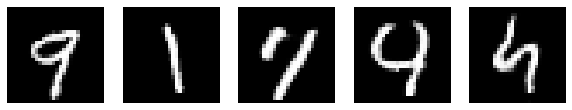

Epoch:4 Loss: g:0.856773168627421 d:1.293093093363444
Time for epoch 4 is 42.243661642074585 sec
___________________________________
5


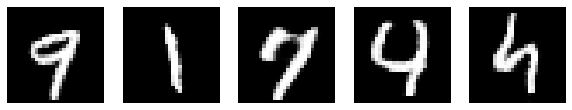

Epoch:5 Loss: g:0.852455625629425 d:1.2895764187494914
Time for epoch 5 is 42.20627784729004 sec
___________________________________
6


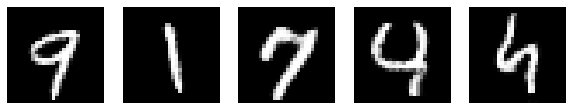

Epoch:6 Loss: g:0.850595467376709 d:1.2918983255386352
Time for epoch 6 is 42.2324697971344 sec
___________________________________
7


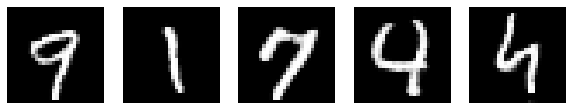

Epoch:7 Loss: g:0.854759734471639 d:1.294123196029663
Time for epoch 7 is 42.2128267288208 sec
___________________________________
8


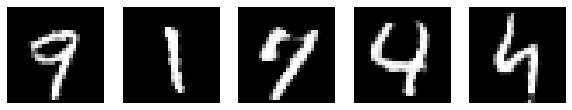

Epoch:8 Loss: g:0.8497904560407002 d:1.2924457864761352
Time for epoch 8 is 42.19501495361328 sec
___________________________________
9


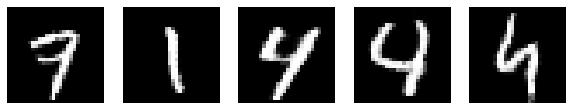

Epoch:9 Loss: g:0.8494651934623718 d:1.2948837306340535
Time for epoch 9 is 42.39679956436157 sec
___________________________________
10


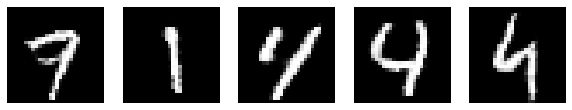

Epoch:10 Loss: g:0.851341200319926 d:1.2924100543340047
Time for epoch 10 is 42.17148232460022 sec
___________________________________
11


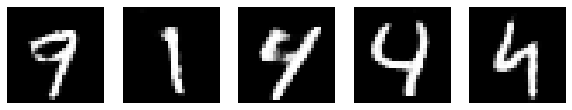

Epoch:11 Loss: g:0.8533689244588216 d:1.292681625811259
Time for epoch 11 is 42.257381439208984 sec
___________________________________
12


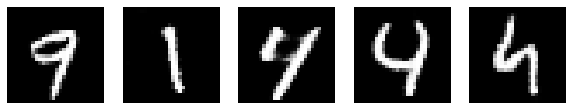

Epoch:12 Loss: g:0.8523843466122946 d:1.2921769999821981
Time for epoch 12 is 42.27419972419739 sec
___________________________________
13


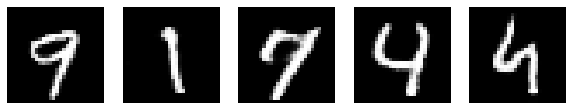

Epoch:13 Loss: g:0.8536399712880453 d:1.293351672490438
Time for epoch 13 is 42.26687574386597 sec
___________________________________
14


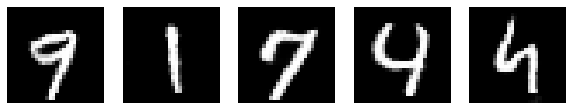

Epoch:14 Loss: g:0.8484443128267924 d:1.2944629055658976
Time for epoch 14 is 42.37558388710022 sec
___________________________________
15


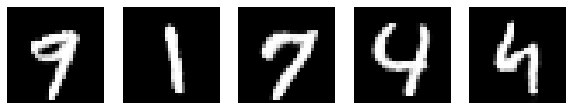

Epoch:15 Loss: g:0.8502207551320394 d:1.2937356488545735
Time for epoch 15 is 42.35499143600464 sec
___________________________________
16


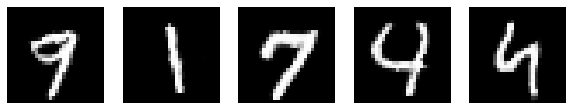

Epoch:16 Loss: g:0.8494912122408549 d:1.2957461568832398
Time for epoch 16 is 42.26830005645752 sec
___________________________________
17


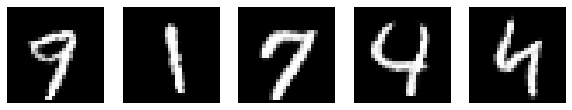

Epoch:17 Loss: g:0.8470038346290588 d:1.2949524361928304
Time for epoch 17 is 42.452842712402344 sec
___________________________________
18


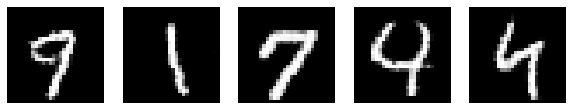

Epoch:18 Loss: g:0.8471476090113322 d:1.293380962308248
Time for epoch 18 is 42.299142599105835 sec
___________________________________
19


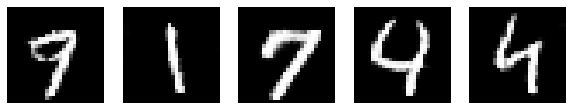

Epoch:19 Loss: g:0.8491177942276001 d:1.294326103337606
Time for epoch 19 is 42.264392375946045 sec
___________________________________
20


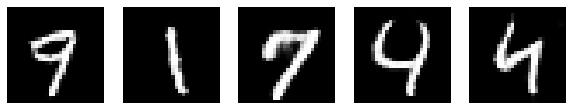

Epoch:20 Loss: g:0.8521351588884989 d:1.2939675463358562
Time for epoch 20 is 42.26961874961853 sec
___________________________________
21


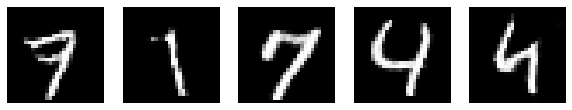

Epoch:21 Loss: g:0.8506679389953613 d:1.294678015200297
Time for epoch 21 is 42.33446502685547 sec
___________________________________
22


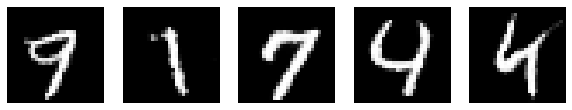

Epoch:22 Loss: g:0.8446713450749715 d:1.2946406210581463
Time for epoch 22 is 42.309932470321655 sec
___________________________________
23


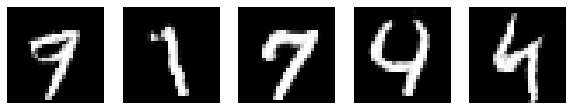

Epoch:23 Loss: g:0.849737168598175 d:1.292589235051473
Time for epoch 23 is 42.238168239593506 sec
___________________________________
24


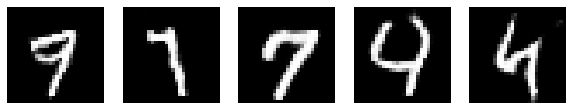

Epoch:24 Loss: g:0.8498822337468466 d:1.2942590401967367
Time for epoch 24 is 42.303922176361084 sec
___________________________________
25


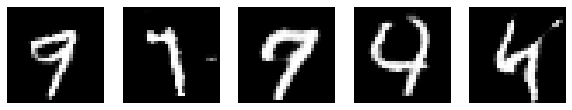

Epoch:25 Loss: g:0.8498384868939718 d:1.294160315132141
Time for epoch 25 is 42.41177797317505 sec
___________________________________
26


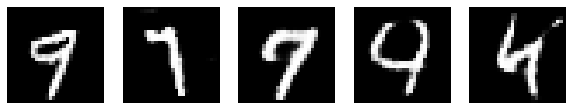

Epoch:26 Loss: g:0.845453762849172 d:1.2991717480341594
Time for epoch 26 is 42.218587160110474 sec
___________________________________
27


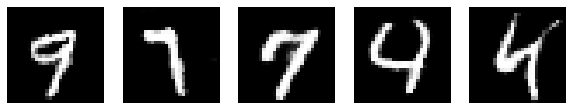

Epoch:27 Loss: g:0.8459748394648234 d:1.2974655923843383
Time for epoch 27 is 42.210386753082275 sec
___________________________________
28


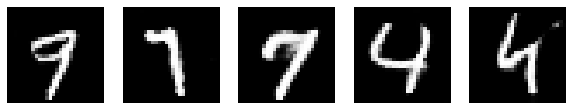

Epoch:28 Loss: g:0.8457662658373515 d:1.297280153020223
Time for epoch 28 is 42.25216102600098 sec
___________________________________
29


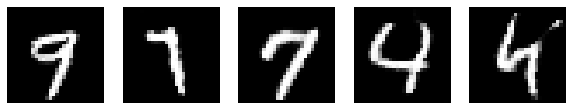

Epoch:29 Loss: g:0.8502179613431294 d:1.2952748618443808
Time for epoch 29 is 42.255507707595825 sec
___________________________________
30


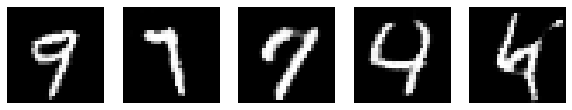

Epoch:30 Loss: g:0.8463026903788249 d:1.2950075915018717
Time for epoch 30 is 42.28607225418091 sec
___________________________________


In [ ]:
checkpoint_dir = './'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = gen_opt,
                                 discriminator_optimizer = disc_opt,
                                 generator = generator,
                                 discriminator = discriminator)

batch_size = 32
buffer_size = 60000
epochs = 30
seed_size = 100
num_gen_examples = 5
seed = tf.random.normal([num_gen_examples, seed_size])

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)
train(train_dataset, epochs)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)3?> 
  image = imageio.imread(filename)
  writer.append_data(image)